## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [2]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [3]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class LSTM v1

In [4]:
# Define your LSTM model here with num_layers LSTM layers and 1 fully connected layer
class LSTMModel_v1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [5]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [6]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [7]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [8]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [9]:
dataset.shape

(71984434, 11)

### See the mean variation for differents interval of time

In [10]:
dataset_station_statut_drop = dataset_station_statut.drop(["docks_available"], axis=1)
dataset_station_statut_drop['time'] = pd.to_datetime(dataset_station_statut_drop['time'], format="mixed")
pivoted_dataset_station_statut_drop = dataset_station_statut_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [11]:
import pandas as pd

# assuming your dataframe is named df and has a datetime index
intervals = ['5min', '10min', '15min', '30min', '60min']
for interval in intervals:
    resampled = pivoted_dataset_station_statut_drop.resample(interval).var().mean().sort_values(ascending=False)
    print(f'Mean Variance for {interval} interval:')
    print(resampled)

Mean Variance for 5min interval:
station_id
70    0.227252
69    0.152443
50    0.144004
61    0.110123
60    0.104654
        ...   
33    0.006550
8     0.006083
23    0.005957
38    0.005068
5     0.004799
Length: 70, dtype: float64
Mean Variance for 10min interval:
station_id
70    0.500550
69    0.343188
50    0.317341
61    0.233667
60    0.210250
        ...   
8     0.011556
33    0.010267
5     0.008726
23    0.008316
38    0.007830
Length: 70, dtype: float64
Mean Variance for 15min interval:
station_id
70    0.783799
69    0.557002
50    0.492731
61    0.346430
65    0.325293
        ...   
8     0.016246
33    0.013776
5     0.012483
38    0.010602
23    0.010149
Length: 70, dtype: float64
Mean Variance for 30min interval:
station_id
70    1.463287
69    1.152336
50    1.010326
61    0.691692
65    0.667708
        ...   
5     0.024140
83    0.024065
33    0.023480
38    0.017727
23    0.014105
Length: 70, dtype: float64
Mean Variance for 60min interval:
station_id
70    2.

# 1/ (Mulivariate) Selection three station to make prediction

### All id station available

In [12]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


In [13]:
dataset_station_id = dataset.loc[dataset['id'].isin([42, 70, 60])]

In [14]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15 19]


In [15]:
dataset_station_id.shape

(3141422, 11)

In [16]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [17]:
dataset_station_id.tail(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
61417386,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:57:02
61417387,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:58:02
61417388,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:59:02


### Drop columns

In [18]:
dataset_station_id_drop = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [19]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01


### Check presence of null and NaN values

In [20]:
dataset_station_id_drop.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [21]:
dataset_station_id_drop[dataset_station_id_drop.isna().any(axis=1)]

,station_id,bikes_available,time


In [22]:
dataset_station_id_drop.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [23]:
dataset_station_id_drop['time'] = pd.to_datetime(dataset_station_id_drop['time'], format="mixed")

In [24]:
dataset_station_id_drop.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [25]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01


In [26]:
dataset_station_id_drop.tail(1)

,station_id,bikes_available,time
61417388,70,15,2015-08-31 23:59:02


### Train

In [27]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [28]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test

In [29]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Print Global Metrics 

In [91]:
def result_prediction(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        y_pred = predictions[:,i]
        y_true = actuals[:,i]

        signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)*100
        if (mape > 1 or mape < 0):
            mape = "ERROR"
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
        maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

        # Ajouter une ligne au tableau avec le nom du mois et les metrics
        data.append(["Global", signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Global', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Global', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each month

In [79]:
def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))

        for name, indice in indices_by_month:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Month', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Month', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each week

In [80]:
def result_prediction_by_week(predictions, actuals):
    indices_by_week = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='W'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_week.append((name.strftime('%W'), indices))

        for name, indice in indices_by_week:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                    mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Week', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Week', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each day

In [81]:
def result_prediction_by_day(predictions, actuals):
    indices_by_day = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='D'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_day.append((name.timetuple().tm_yday, indices))

        for name, indice in indices_by_day:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each hour

In [82]:
def result_prediction_by_hour(predictions, actuals):
    indices_by_hour = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='H'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_hour.append((name, indices))

        for name, indice in indices_by_hour:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            if len(y_pred) != 0 and len(y_true != 0) :
                signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred)*100
                if (mape > 1 or mape < 0):
                    mape = "ERROR"
                smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

                # Ajouter une ligne au tableau avec le nom du mois et les metrics
                data.append([f'{name.timetuple().tm_yday} / {name.hour}', signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day / Hour', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day / Hour', inplace=True)
    # Retourner le DataFrame
    return df

## Trying to forecast the availability of bikes 

In [34]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
pivoted_df_station_id = dataset_station_id_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [36]:
pivoted_df_station_id.head(10)

station_id,42,60,70
time,,,
2013-08-29 12:06:01,7.0,8.0,0.0
2013-08-29 12:07:01,7.0,8.0,0.0
2013-08-29 12:08:01,7.0,8.0,0.0
2013-08-29 12:09:01,7.0,8.0,0.0
2013-08-29 12:10:01,7.0,8.0,0.0
2013-08-29 12:11:01,7.0,8.0,0.0
2013-08-29 12:12:01,7.0,8.0,0.0
2013-08-29 12:13:01,7.0,8.0,0.0
2013-08-29 12:15:01,7.0,8.0,0.0


### First Experimentation

#### Use 15 min to predict the 5th next min

In [37]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='5min'), dropna=True).mean()

In [38]:
# window_size = "10min"
# df_weekday_hour = group.rolling(window_size).mean()

In [39]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])    

752

In [40]:
df_weekday_hour = df_weekday_hour.dropna()

In [41]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [42]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [43]:
df_weekday_hour_prep.head(4)

station_id,42,60,70
time,,,
2013-08-29 12:05:00,7.0,8.0,0.00
2013-08-29 12:10:00,7.0,8.0,0.00
2013-08-29 12:15:00,7.0,8.5,0.25
2013-08-29 12:20:00,7.0,9.5,1.00


In [44]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42,60,70
time,,,


In [45]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [46]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 3

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 32757.4600, Validation Loss: 1.8048
Epoch 2/50, Training Loss: 3283.1087, Validation Loss: 0.7675
Epoch 3/50, Training Loss: 2478.6757, Validation Loss: 0.7007
Epoch 4/50, Training Loss: 2322.3768, Validation Loss: 0.6935
Epoch 5/50, Training Loss: 2230.6273, Validation Loss: 0.6672
Epoch 6/50, Training Loss: 2159.7360, Validation Loss: 0.6538
Epoch 7/50, Training Loss: 2122.6830, Validation Loss: 0.6334
Epoch 8/50, Training Loss: 2091.1998, Validation Loss: 0.6245
Epoch 9/50, Training Loss: 2061.8380, Validation Loss: 0.6195
Epoch 10/50, Training Loss: 2036.0528, Validation Loss: 0.6170
Epoch 11/50, Training Loss: 2014.7226, Validation Loss: 0.6164
Epoch 12/50, Training Loss: 1994.0564, Validation Loss: 0.6130
Epoch 13/50, Training Loss: 1978.0781, Validation Loss: 0.6101
Epoch 14/50, Training Loss: 1965.7662, Validation Loss: 0.6085
Epoch 15/50, Training Loss: 1954.3267, Validation Loss: 0.6082
Epoch 16/50, Training Loss: 1943.6401, Validation Loss: 0.6074


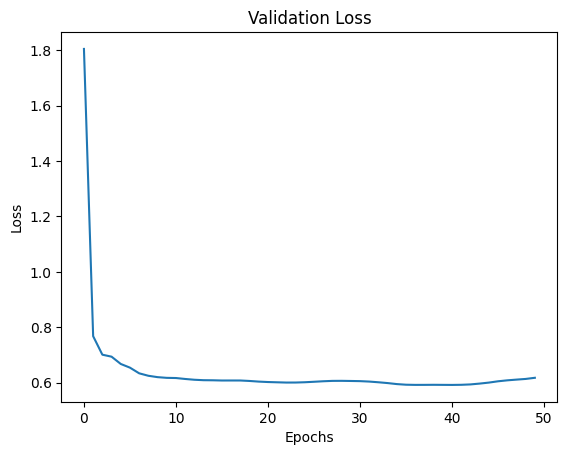

In [48]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 50)

In [49]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 0.6223


In [92]:
result_prediction(predictions_n_to_n, actuals_n_to_n)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.242796,0.437257,ERROR,6.79227,6.348655


In [83]:
results_month = result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)
results_month

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.216340,0.395842,ERROR,5.167709,4.964477
February,+,0.222869,0.391962,ERROR,6.478659,6.239687
March,+,0.276241,0.463708,ERROR,7.366541,6.980489
April,+,0.257475,0.445244,ERROR,7.686724,7.081585
May,+,0.233394,0.418431,ERROR,7.335451,6.878258
June,+,0.245882,0.475572,ERROR,7.786386,7.074195
July,+,0.249251,0.453523,ERROR,5.604598,5.224136
August,+,0.239125,0.443285,ERROR,6.922568,6.363135


In [84]:
results_week = result_prediction_by_week(predictions_n_to_n, actuals_n_to_n)
results_week

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.149961,0.213039,ERROR,2.133689,2.153791
01,+,0.216693,0.344383,ERROR,5.996629,5.653255
02,+,0.227023,0.420132,ERROR,5.972733,5.640951
03,+,0.222470,0.435833,ERROR,4.321463,4.332950
04,+,0.226060,0.427273,ERROR,5.479608,5.251889
05,+,0.208879,0.384242,ERROR,5.252551,5.230891
06,+,0.244850,0.446214,ERROR,7.295945,6.998755
07,+,0.212241,0.373389,ERROR,5.845537,5.606289
08,+,0.228197,0.359414,ERROR,7.742301,7.354627


In [89]:
results_day = result_prediction_by_day(predictions_n_to_n, actuals_n_to_n)
results_day.sort_values(["SMAPE"], ascending=False)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
223,+,0.315343,0.584654,ERROR,30.416979,25.453985
41,+,0.328853,0.529012,ERROR,21.222510,19.039099
83,+,0.321496,0.511865,ERROR,20.572292,18.779747
232,+,0.239035,0.427148,ERROR,19.942645,16.504349
167,+,0.218512,0.504991,ERROR,19.583087,16.595025
...,...,...,...,...,...,...
241,+,0.113635,0.232491,ERROR,1.634750,1.651944
192,+,0.152263,0.318334,ERROR,1.620084,1.621439
11,+,0.158449,0.201703,ERROR,1.536775,1.546762


In [90]:
results_hour = result_prediction_by_hour(predictions_n_to_n, actuals_n_to_n)
results_hour.sort_values(["SMAPE"], ascending=False)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
92 / 18,+,0.633247,0.688090,ERROR,200.000000,150.554551
200 / 17,-,0.177278,0.233558,ERROR,193.581137,143.387038
223 / 5,+,0.244848,0.290058,ERROR,188.007762,149.502494
167 / 18,-,0.276326,0.526148,ERROR,183.627398,138.102039
99 / 10,+,0.897841,1.319339,ERROR,181.275937,139.933995
...,...,...,...,...,...,...
241 / 0,+,0.010072,0.013396,0.111906,0.111948,0.111905
241 / 2,+,0.008601,0.008601,0.095567,0.095521,0.095566
241 / 1,+,0.008601,0.008601,0.095567,0.095521,0.095566


##### f(a(t), b(t), c(t)) = a(t+1)

In [56]:
df_weekday_hour_prep.head(3)

station_id,42,60,70
time,,,
2013-08-29 12:05:00,7.0,8.0,0.00
2013-08-29 12:10:00,7.0,8.0,0.00
2013-08-29 12:15:00,7.0,8.5,0.25


In [57]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride, drop=[1, 2])
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride, drop=[1, 2])
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride, drop=[1, 2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Training Loss: 10606.2036, Validation Loss: 0.3126
Epoch 2/100, Training Loss: 993.5610, Validation Loss: 0.2676
Epoch 3/100, Training Loss: 890.2898, Validation Loss: 0.1997
Epoch 4/100, Training Loss: 731.9185, Validation Loss: 0.2056
Epoch 5/100, Training Loss: 634.8156, Validation Loss: 0.2229
Epoch 6/100, Training Loss: 622.3815, Validation Loss: 0.1780
Epoch 7/100, Training Loss: 610.7872, Validation Loss: 0.1555
Epoch 8/100, Training Loss: 599.5106, Validation Loss: 0.1526
Epoch 9/100, Training Loss: 595.4207, Validation Loss: 0.1519
Epoch 10/100, Training Loss: 585.6681, Validation Loss: 0.1503
Epoch 11/100, Training Loss: 581.1785, Validation Loss: 0.1511
Epoch 12/100, Training Loss: 578.0134, Validation Loss: 0.1498
Epoch 13/100, Training Loss: 572.1232, Validation Loss: 0.1495
Epoch 14/100, Training Loss: 569.8441, Validation Loss: 0.1492
Epoch 15/100, Training Loss: 564.3996, Validation Loss: 0.1494
Epoch 16/100, Training Loss: 561.3886, Validation Loss: 0.1492

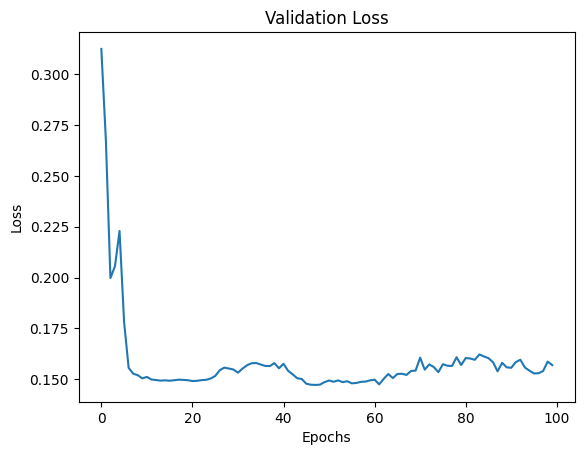

In [59]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 100)

In [60]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_1, actuals_n_to_1 = test_model(best_model, test_loader, criterion)

Test Loss: 0.1747


In [93]:
result_prediction(predictions_n_to_1, actuals_n_to_1)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.200451,0.417926,ERROR,5.963532,5.419293


In [66]:
results_month = result_prediction_by_month(predictions_n_to_1, actuals_n_to_1)
results_month

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.165675,ERROR,0.042667,0.371582,0.039997
February,+,0.173152,ERROR,0.055827,0.374586,0.051544
March,+,0.231881,ERROR,0.062813,0.442100,0.058118
April,+,0.218434,ERROR,0.069035,0.426795,0.062308
May,+,0.187413,ERROR,0.062578,0.393073,0.056490
June,+,0.211644,ERROR,0.070659,0.461335,0.062757
July,+,0.212766,ERROR,0.051079,0.435179,0.046623
August,+,0.200525,ERROR,0.062543,0.427226,0.055830


In [67]:
results_week = result_prediction_by_week(predictions_n_to_1, actuals_n_to_1)
results_week

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.086603,0.012373,0.012324,0.171585,0.012348
01,+,0.161095,ERROR,0.051252,0.313562,0.046547
02,+,0.169951,ERROR,0.048703,0.392830,0.044219
03,+,0.175542,0.038524,0.034793,0.410988,0.034523
04,+,0.185756,ERROR,0.046853,0.412409,0.044677
05,+,0.156982,ERROR,0.042778,0.358989,0.041069
06,+,0.197556,ERROR,0.062823,0.453046,0.057830
07,+,0.170867,ERROR,0.052185,0.346236,0.048147
08,+,0.169074,ERROR,0.066864,0.326785,0.060494


In [68]:
results_day = result_prediction_by_day(predictions_n_to_1, actuals_n_to_1)
results_day

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
1,+,0.094330,0.016055,0.016254,0.195868,0.015997
2,+,0.075526,0.008801,0.008829,0.174287,0.008790
3,+,0.081011,0.010601,0.010500,0.164863,0.010585
4,+,0.099409,0.015875,0.015676,0.162196,0.015844
5,+,0.224041,ERROR,0.074699,0.417142,0.069384
...,...,...,...,...,...,...
239,-,0.251758,0.043274,0.042482,0.450942,0.042793
240,+,0.241608,0.055308,0.054955,0.475143,0.053196
241,+,0.097816,0.013889,0.013792,0.221093,0.013817


In [69]:
results_hour = result_prediction_by_hour(predictions_n_to_1, actuals_n_to_1)
results_hour

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
1 / 12,+,0.068025,0.015462,0.015317,0.071073,0.015460
1 / 13,+,0.079696,0.019924,0.019725,0.080305,0.019921
1 / 14,-,0.292364,0.05451,0.058086,0.502269,0.054026
1 / 15,+,0.167616,0.027868,0.026571,0.318098,0.027717
1 / 16,-,0.135776,0.019397,0.020076,0.270865,0.019337
...,...,...,...,...,...,...
243 / 9,-,0.805614,0.086928,0.092253,1.122026,0.086023
243 / 10,+,0.384437,0.031599,0.030748,0.637267,0.031478
243 / 11,+,0.178354,0.020479,0.019867,0.311955,0.020447
